<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This notebook contains all functions related to creating spectra from FASTA files. In brief, what we are doing is the following:

1. Read a FASTA file and in silico digest the proteins to generate peptides
2. For each peptide, calculate a theoretical spectrum and precursor mass
3. Save spectra

Currently, `numba` has only limited string support. A lot of the functions are therefore Python-native.

## Cleaving

We use regular expressions to find potential cleavage sites for cleaving and write the wrapper [`cleave_sequence`](https://mannlabs.github.io/alphapept/fasta.html#cleave_sequence) to use it.

In [1]:
#| echo: false
#| output: asis
show_doc(cleave_sequence)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L33){target="_blank" style="float:right; font-size:smaller"}

### cleave_sequence

>      cleave_sequence (sequence:str='', n_missed_cleavages:int=0,
>                       protease:str='trypsin', pep_length_min:int=6,
>                       pep_length_max:int=65, **kwargs)

Cleave a sequence with a given protease. Filters to have a minimum and maximum length.
Args:
    sequence (str): the given (protein) sequence.
    n_missed_cleavages (int): the number of max missed cleavages.
    protease (str): the protease/enzyme name, the regular expression can be found in alphapept.constants.protease_dict.
    pep_length_min (int): min peptide length.
    pep_length_max (int): max peptide length.
Returns:
    list (of str): cleaved peptide sequences with missed cleavages.

In [2]:
#| echo: false
#| output: asis
show_doc(get_missed_cleavages)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L17){target="_blank" style="float:right; font-size:smaller"}

### get_missed_cleavages

>      get_missed_cleavages (sequences:list, n_missed_cleavages:int)

Combine cleaved sequences to get sequences with missed cleavages
Args:
    seqeuences (list of str): the list of cleaved sequences, no missed cleavages are there.
    n_missed_cleavages (int): the number of miss cleavage sites.
Returns:
    list (of str): the sequences with missed cleavages.

In [ ]:
protease = "trypsin"
n_missed_cleavages = 0
pep_length_min, pep_length_max = 6, 65

cleave_sequence('ABCDEFGHIJKLMNOPQRST', n_missed_cleavages, protease, pep_length_min, pep_length_max)

['ABCDEFGHIJK', 'LMNOPQR']

## Counting missed and internal cleavages
The following are helper functions to retrieve the number of missed cleavages and internal cleavage sites for each sequence.

In [3]:
#| echo: false
#| output: asis
show_doc(count_internal_cleavages)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L92){target="_blank" style="float:right; font-size:smaller"}

### count_internal_cleavages

>      count_internal_cleavages (sequence:str='', protease:str='trypsin',
>                                **kwargs)

Counts the number of internal cleavage sites for a given sequence and protease
Args:
    sequence (str): the given (peptide) sequence.
    protease (str): the protease/enzyme name, the regular expression can be found in alphapept.constants.protease_dict.
Returns:
    int (0 or 1): if the sequence is from internal cleavage.

In [4]:
#| echo: false
#| output: asis
show_doc(count_missed_cleavages)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L77){target="_blank" style="float:right; font-size:smaller"}

### count_missed_cleavages

>      count_missed_cleavages (sequence:str='', protease:str='trypsin',
>                              **kwargs)

Counts the number of missed cleavages for a given sequence and protease
Args:
    sequence (str): the given (peptide) sequence.
    protease (str): the protease/enzyme name, the regular expression can be found in alphapept.constants.protease_dict.
Returns:
    int: the number of miss cleavages

In [ ]:
protease = "trypsin"
print(count_missed_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

protease = "trypsin"
print(count_internal_cleavages('ABCDEFGHIJKLMNOPQRST', protease))

2
1


## Parsing

Peptides are composed out of amino acids that are written in capital letters - `PEPTIDE`. To distinguish modifications, they are written in lowercase such as `PEPTIoxDE` and can be of arbitrary length. For a modified amino acid (AA), the modification precedes the letter of the amino acid. Decoys are indicated with an underscore. Therefore, the [`parse`](https://mannlabs.github.io/alphapept/fasta.html#parse) function splits after `_`. When parsing, the peptide string is converted into a `numba`-compatible list, like so: `PEPoxTIDE` -> `[P, E, P, oxT, I, D, E]`. This allows that we can use the `mass_dict` from `alphapept.constants` to directly determine the masses for the corresponding amino acids.

In [5]:
#| echo: false
#| output: asis
show_doc(list_to_numba)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L136){target="_blank" style="float:right; font-size:smaller"}

### list_to_numba

>      list_to_numba (a_list)

Convert Python list to numba.typed.List
Args: 
    a_list (list): Python list.
Return:
    List (numba.typed.List): Numba typed list.

In [6]:
#| echo: false
#| output: asis
show_doc(parse)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L115){target="_blank" style="float:right; font-size:smaller"}

### parse

>      parse (peptide:str)

Parser to parse peptide strings
Args: 
    peptide (str): modified peptide sequence.
Return:
    List (numba.typed.List): a list of animo acids and modified amono acids

In [ ]:
print(parse('PEPTIDE'))
print(parse('PEPoxTIDE'))

[P, E, P, T, I, D, E, ...]
[P, E, P, oxT, I, D, E, ...]


## Decoy

The decoy strategy employed is a pseudo-reversal of the peptide sequence, keeping only the terminal amino acid and reversing the rest. Additionally, we can call the functions [`swap_KR`](https://mannlabs.github.io/alphapept/fasta.html#swap_kr) and and [`swap_AL`](https://mannlabs.github.io/alphapept/fasta.html#swap_al) that will swap the respective AAs. The function [`swap_KR`](https://mannlabs.github.io/alphapept/fasta.html#swap_kr) will only swap terminal AAs. The swapping functions only work if the AA is not modified.

In [7]:
#| echo: false
#| output: asis
show_doc(add_decoy_tag)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L240){target="_blank" style="float:right; font-size:smaller"}

### add_decoy_tag

>      add_decoy_tag (peptides)

Adds a '_decoy' tag to a list of peptides

In [8]:
#| echo: false
#| output: asis
show_doc(get_decoys)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L225){target="_blank" style="float:right; font-size:smaller"}

### get_decoys

>      get_decoys (peptide_list, pseudo_reverse=False, AL_swap=False,
>                  KR_swap=False, **kwargs)

Wrapper to get decoys for lists of peptides
Args:
    peptide_list (list): the list of peptides to be reversed.
    pseudo_reverse (bool): If True, reverse the peptide bug keep the C-terminal amino acid; otherwise reverse the whole peptide. (Default: False)
    AL_swap (bool): replace A with L, and vice versa. (Default: False)
    KR_swap (bool): replace K with R at the C-terminal, and vice versa. (Default: False)
Returns:
    list (of str): a list of decoy peptides

In [9]:
#| echo: false
#| output: asis
show_doc(swap_AL)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L202){target="_blank" style="float:right; font-size:smaller"}

### swap_AL

>      swap_AL (peptide:str)

Swaps a A with L. Note: Only if AA is not modified.
Args:
    peptide (str): peptide.

Returns:
    str: peptide with swapped ALs.

In [10]:
#| echo: false
#| output: asis
show_doc(swap_KR)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L183){target="_blank" style="float:right; font-size:smaller"}

### swap_KR

>      swap_KR (peptide:str)

Swaps a terminal K or R. Note: Only if AA is not modified.

Args:
    peptide (str): peptide.

Returns:
    str: peptide with swapped KRs.

In [11]:
#| echo: false
#| output: asis
show_doc(get_decoy_sequence)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L153){target="_blank" style="float:right; font-size:smaller"}

### get_decoy_sequence

>      get_decoy_sequence (peptide:str, pseudo_reverse:bool=False,
>                          AL_swap:bool=False, KR_swap:bool=False)

Reverses a sequence and adds the '_decoy' tag.
Args:
    peptide (str): modified peptide to be reversed.
    pseudo_reverse (bool): If True, reverse the peptide bug keep the C-terminal amino acid; otherwise reverse the whole peptide. (Default: False)
    AL_swap (bool): replace A with L, and vice versa. (Default: False)
    KR_swap (bool): replace K with R at the C-terminal, and vice versa. (Default: False)
Returns:
    str: reversed peptide ending with the '_decoy' tag.

In [ ]:
print(swap_AL(parse('KKKALKKK')))
print(swap_KR(parse('AAAKRAAA')))

[K, K, K, L, A, K, K, K, ...]
[A, A, A, K, R, A, A, A, ...]


In [ ]:
print(get_decoy_sequence('PEPTIDE'))

EDITPEP


In [ ]:
print(get_decoys(['ABC','DEF','GHI']))

['CBA', 'FED', 'IHG']


## Modifications

To add modifications to the peptides, we distinguish fixed and variable modifications. Additionally, we make a distinction between whether the modification is only terminal or not. 

### Fixed Modifications
Fixed modifications are implemented by passing a list with modified AAs that should be replaced. As a AA is only one letter, the remainder is the modification. 

In [12]:
#| echo: false
#| output: asis
show_doc(add_fixed_mods)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L247){target="_blank" style="float:right; font-size:smaller"}

### add_fixed_mods

>      add_fixed_mods (seqs:list, mods_fixed:list, **kwargs)

Adds fixed modifications to sequences.
Args:
    seqs (list of str): sequences to add fixed modifications
    mods_fixed (list of str): the string list of fixed modifications. Each modification string must be in lower case, except for that the last letter must be the modified amino acid (e.g. oxidation on M should be oxM).
Returns:
    list (of str): the list of the modified sequences. 'ABCDEF' with fixed mod 'cC' will be 'ABcCDEF'.

In [ ]:
mods_fixed = ['cC','bB']
peptide_list = ['ABCDEF']

add_fixed_mods(peptide_list, mods_fixed)

['AbBcCDEF']

In [ ]:
mods_fixed = ['aA','cC','bB']
peptide_list = ['cABCDEF']

add_fixed_mods(peptide_list, mods_fixed)

['caAbBcCDEF']

### Variable Modifications

To employ variable modifications, we loop through each variable modification and each position of the peptide and add them to the peptide list. For each iteration in get_isoforms, one more variable modification will be added.

In [13]:
#| echo: false
#| output: asis
show_doc(get_isoforms)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L285){target="_blank" style="float:right; font-size:smaller"}

### get_isoforms

>      get_isoforms (mods_variable_dict:dict, peptide:str, isoforms_max:int,
>                    n_modifications_max:int=None)

Function to generate modified forms (with variable modifications) for a given peptide - returns a list of modified forms.
The original sequence is included in the list
Args:
    mods_variable_dict (dict): Dicitionary with modifications. The key is AA, and value is the modified form (e.g. oxM).
    peptide (str): the peptide sequence to generate modified forms.
    isoforms_max (int): max number of modified forms to generate per peptide.
    n_modifications_max (int, optional): max number of variable modifications per peptide.
Returns:
    list (of str): the list of peptide forms for the given peptide

In [14]:
#| echo: false
#| output: asis
show_doc(add_variable_mod)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L264){target="_blank" style="float:right; font-size:smaller"}

### add_variable_mod

>      add_variable_mod (peps:list, mods_variable_dict:dict)

Function to add variable modification to a list of peptides.
Args:
    peps (list): List of peptides.
    mods_variable_dict (dict): Dicitionary with modifications. The key is AA, and value is the modified form (e.g. oxM). 
Returns:
    list : the list of peptide forms for the given peptide.

In [ ]:
mods_variable_dict = {'S':'pS','P':'pP','M':'oxM'}
isoforms_max = 1024

print(get_isoforms(mods_variable_dict, 'PEPTIDE', isoforms_max))
print(get_isoforms(mods_variable_dict, 'AMAMA', isoforms_max))
print(get_isoforms(mods_variable_dict, 'AMAMA', isoforms_max, n_modifications_max=1))

['PEPTIDE', 'pPEPTIDE', 'PEpPTIDE', 'pPEpPTIDE']
['AMAMA', 'AoxMAMA', 'AMAoxMA', 'AoxMAoxMA']
['AMAMA', 'AoxMAMA', 'AMAoxMA']


Lastly, we define the wrapper [`add_variable_mods`](https://mannlabs.github.io/alphapept/fasta.html#add_variable_mods) so that the functions can be called for lists of peptides and a list of variable modifications.

In [15]:
#| echo: false
#| output: asis
show_doc(add_variable_mods)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L333){target="_blank" style="float:right; font-size:smaller"}

### add_variable_mods

>      add_variable_mods (peptide_list:list, mods_variable:list,
>                         isoforms_max:int, n_modifications_max:int, **kwargs)

Add variable modifications to the peptide list
Args:
    peptide_list (list of str): peptide list.
    mods_variable (list of str): modification list.
    isoforms_max (int): max number of modified forms per peptide sequence.
    n_modifications_max (int): max number of variable modifications per peptide.
Returns:
    list (of str): list of modified sequences for the given peptide list.

In [ ]:
peptide_list = ['AMA', 'AAC']
mods_variable = ['oxM','amC']
isoforms_max = 1024
n_modifications_max = 10

add_variable_mods(peptide_list, mods_variable, isoforms_max, n_modifications_max)

['AMA', 'AoxMA', 'AAC', 'AAamC']

### Terminal Modifications - Fixed

To handle terminal modifications, we use the following convention:

* `<` for the left side (N-terminal)
* `>` for the right side (C-Terminal)

Additionally, if we want to have a terminal modification on any AA we indicate this `^`.

In [16]:
#| echo: false
#| output: asis
show_doc(add_fixed_mods_terminal)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L388){target="_blank" style="float:right; font-size:smaller"}

### add_fixed_mods_terminal

>      add_fixed_mods_terminal (peptides:list, mods_fixed_terminal:list,
>                               **kwargs)

Wrapper to add fixed mods on sequences and lists of mods
Args:
    peptides (list of str): peptide list.
    mods_fixed_terminal (list of str): list of fixed terminal mods.
Raises:
    "Invalid fixed terminal modification {mod}" exception for the given mod.
Returns:
    list (of str): list of peptides with modification added.

In [17]:
#| echo: false
#| output: asis
show_doc(add_fixed_mod_terminal)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L363){target="_blank" style="float:right; font-size:smaller"}

### add_fixed_mod_terminal

>      add_fixed_mod_terminal (peptides:list, mod:str)

Adds fixed terminal modifications
Args:
    peptides (list of str): peptide list.
    mod (str): n-term mod contains '<^' (e.g. a<^ for Acetyl@N-term); c-term mod contains '>^'.
Raises:
    "Invalid fixed terminal modification 'mod name'" for the given mod.
Returns:
    list (of str): list of peptides with modification added.

In [ ]:
peptide = ['AMAMA']

print(f'Starting with peptide {peptide}')
print('Any n-term modified with x (x<^):', add_fixed_mods_terminal(peptide, ['x<^']))
print('Any c-term modified with x (x>^):', add_fixed_mods_terminal(peptide, ['x>^']))
print('Only A on n-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x<A']))
print('Only A on c-term modified with x (x<A):', add_fixed_mods_terminal(peptide, ['x>A']))

Starting with peptide ['AMAMA']
Any n-term modified with x (x<^): ['xAMAMA']
Any c-term modified with x (x>^): ['AMAMxA']
Only A on n-term modified with x (x<A): ['xAMAMA']
Only A on c-term modified with x (x<A): ['AMAMxA']


### Terminal Modifications - Variable

Lastly, to handle terminal variable modifications, we use the function [`add_variable_mods_terminal`](https://mannlabs.github.io/alphapept/fasta.html#add_variable_mods_terminal). As the modification can only be at the terminal end, this function only adds a peptide where the terminal end is modified.

In [18]:
#| echo: false
#| output: asis
show_doc(get_unique_peptides)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L440){target="_blank" style="float:right; font-size:smaller"}

### get_unique_peptides

>      get_unique_peptides (peptides:list)

Function to return unique elements from list.
Args:
    peptides (list of str): peptide list.
Returns:
    list (of str): list of peptides (unique).

In [19]:
#| echo: false
#| output: asis
show_doc(add_variable_mods_terminal)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L408){target="_blank" style="float:right; font-size:smaller"}

### add_variable_mods_terminal

>      add_variable_mods_terminal (peptides:list, mods_variable_terminal:list,
>                                  **kwargs)

Function to add variable terminal modifications.
Args:
    peptides (list of str): peptide list.
    mods_variable_terminal (list of str): list of variable terminal mods.
Returns:
    list (of str): list of peptides with modification added.

In [ ]:
peptide_list = ['AMAMA']
add_variable_mods_terminal(peptide_list, ['x<^'])

['xAMAMA', 'AMAMA']

### Generating Peptides

Lastly, we put all the functions into a wrapper [`generate_peptides`](https://mannlabs.github.io/alphapept/fasta.html#generate_peptides). It will accept a peptide and a dictionary with settings so that we can get all modified peptides.

In [20]:
#| echo: false
#| output: asis
show_doc(check_peptide)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L506){target="_blank" style="float:right; font-size:smaller"}

### check_peptide

>      check_peptide (peptide:str, AAs:set)

Check if the peptide contains non-AA letters.
Args:
    peptide (str): peptide sequence.
    AAs (set): the set of legal amino acids. See alphapept.constants.AAs
Returns:
    bool: True if all letters in the peptide is the subset of AAs, otherwise False

In [21]:
#| echo: false
#| output: asis
show_doc(generate_peptides)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L451){target="_blank" style="float:right; font-size:smaller"}

### generate_peptides

>      generate_peptides (peptide:str, **kwargs)

Wrapper to get modified peptides (fixed and variable mods) from a peptide.

Args:
    peptide (str): the given peptide sequence.
Returns:
    list (of str): all modified peptides.

TODO:
    There can be some edge-cases which are not defined yet.
    Example:
    Setting the same fixed modification - once for all peptides and once for only terminal for the protein.
    The modification will then be applied twice.

In [ ]:
kwargs = {}

kwargs["protease"] = "trypsin"
kwargs["n_missed_cleavages"] = 2
kwargs["pep_length_min"] = 6
kwargs["pep_length_max"] = 27
kwargs["mods_variable"] = ["oxM"]
kwargs["mods_variable_terminal"] = []
kwargs["mods_fixed"] = ["cC"]
kwargs["mods_fixed_terminal"] = []
kwargs["mods_fixed_terminal_prot"] = []
kwargs["mods_variable_terminal_prot"]  = ['a<^']
kwargs["isoforms_max"] = 1024
kwargs["n_modifications_max"] = None

generate_peptides('PEPTIDEM', **kwargs)

['aPEPTIDEM',
 'aPEPTIDEoxM',
 'MEDITPEaP_decoy',
 'oxMEDITPEaP_decoy',
 'PEPTIDEM',
 'PEPTIDEoxM',
 'MEDITPEP_decoy',
 'oxMEDITPEP_decoy']

## Mass Calculations

Using the `mass_dict` from `constants` and being able to parse sequences with [`parse`](https://mannlabs.github.io/alphapept/fasta.html#parse), one can simply look up the masses for each modified or unmodified amino acid and add everything up.

### Precursor

To calculate the mass of the neutral precursor, we start with the mass of an $H_2O$ and add the masses of all amino acids of the sequence.

In [22]:
#| echo: false
#| output: asis
show_doc(get_precmass)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L527){target="_blank" style="float:right; font-size:smaller"}

### get_precmass

>      get_precmass (parsed_pep:list, mass_dict:numba.typed.typeddict.Dict)

Calculate the mass of the neutral precursor
Args:
    parsed_pep (list or numba.typed.List of str): the list of amino acids and modified amono acids.
    mass_dict (numba.typed.Dict): key is the amino acid or the modified amino acid, and the value is the mass.
Returns:
    float: the peptide neutral mass.

In [ ]:
get_precmass(parse('PEPTIDE'), constants.mass_dict)

799.35996420346

### Fragments

Likewise, we can calculate the masses of the fragment ions. We employ two functions: [`get_fragmass`](https://mannlabs.github.io/alphapept/fasta.html#get_fragmass) and [`get_frag_dict`](https://mannlabs.github.io/alphapept/fasta.html#get_frag_dict). 

[`get_fragmass`](https://mannlabs.github.io/alphapept/fasta.html#get_fragmass) is a fast, `numba`-compatible function that calculates the fragment masses and returns an array indicating whether the ion-type was `b` or `y`. 

[`get_frag_dict`](https://mannlabs.github.io/alphapept/fasta.html#get_frag_dict) instead is not `numba`-compatible and hence a bit slower. It returns a dictionary with the respective ion and can be used for plotting theoretical spectra.

In [23]:
#| echo: false
#| output: asis
show_doc(get_fragmass)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L546){target="_blank" style="float:right; font-size:smaller"}

### get_fragmass

>      get_fragmass (parsed_pep:list, mass_dict:numba.typed.typeddict.Dict)

Calculate the masses of the fragment ions
Args:
    parsed_pep (numba.typed.List of str): the list of amino acids and modified amono acids.
    mass_dict (numba.typed.Dict): key is the amino acid or the modified amino acid, and the value is the mass.
Returns:
    Tuple[np.ndarray(np.float64), np.ndarray(np.int8)]: the fragment masses and the fragment types (represented as np.int8). 
    For a fragment type, positive value means the b-ion, the value indicates the position (b1, b2, b3...); the negative value means
    the y-ion, the absolute value indicates the position (y1, y2, ...).

In [ ]:
get_fragmass(parse('PEPTIDE'), constants.mass_dict)

(array([ 98.06004033, 227.10263343, 324.15539729, 425.20307579,
        538.28713979, 653.31408289, 148.06043425, 263.08737735,
        376.17144135, 477.21911985, 574.27188371, 703.31447681]),
 array([ 1,  2,  3,  4,  5,  6, -1, -2, -3, -4, -5, -6], dtype=int8))

In [24]:
#| echo: false
#| output: asis
show_doc(get_frag_dict)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L583){target="_blank" style="float:right; font-size:smaller"}

### get_frag_dict

>      get_frag_dict (parsed_pep:list, mass_dict:dict)

Calculate the masses of the fragment ions
Args:
    parsed_pep (list or numba.typed.List of str): the list of amino acids and modified amono acids.
    mass_dict (numba.typed.Dict): key is the amino acid or the modified amino acid, and the value is the mass.
Returns:
    dict{str:float}: key is the fragment type (b1, b2, ..., y1, y2, ...), value is fragment mass.

In [ ]:
get_frag_dict(parse('PEPTIDE'), constants.mass_dict)

{'b1': 98.06004032687,
 'b2': 227.10263342687,
 'b3': 324.15539728686997,
 'b4': 425.20307578687,
 'b5': 538.28713978687,
 'b6': 653.31408288687,
 'y1': 148.06043425033,
 'y2': 263.08737735033,
 'y3': 376.17144135033,
 'y4': 477.21911985033,
 'y5': 574.27188371033,
 'y6': 703.31447681033}

This allows us also to generate the theoretical isotopes for a fragment:

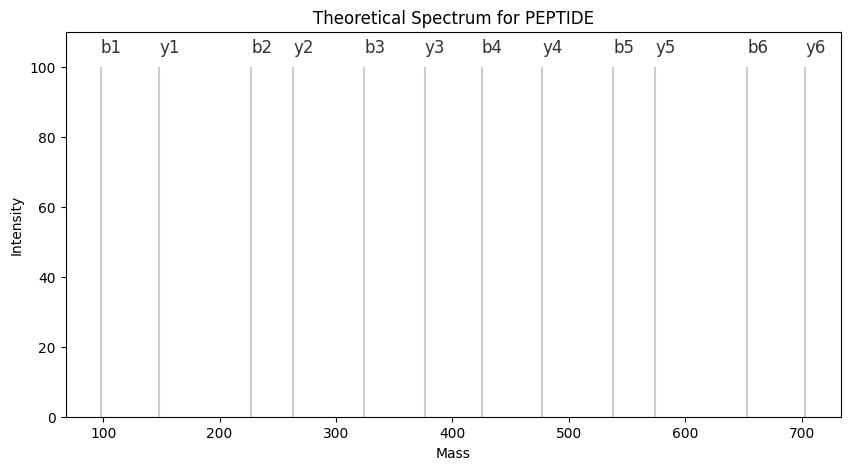

In [ ]:
import matplotlib.pyplot as plt

peptide = 'PEPTIDE'

frag_dict = get_frag_dict(parse(peptide), constants.mass_dict)

db_frag = list(frag_dict.values())
db_int = [100 for _ in db_frag]

plt.figure(figsize=(10,5))
plt.vlines(db_frag, 0, db_int, "k", label="DB", alpha=0.2)

for _ in frag_dict.keys():
    plt.text(frag_dict[_], 104, _, fontsize=12, alpha = 0.8)
    
plt.title('Theoretical Spectrum for {}'.format(peptide))
plt.xlabel('Mass')
plt.ylabel('Intensity')
plt.ylim([0,110])
plt.show()

### Spectra

The function [`get_spectrum`](https://mannlabs.github.io/alphapept/fasta.html#get_spectrum) returns a tuple with the following content:

* precursor mass
* peptide sequence
* fragmasses
* fragtypes

Likewise, [`get_spectra`](https://mannlabs.github.io/alphapept/fasta.html#get_spectra) returns a list of tuples. We employ a list of tuples here as this way, we can sort them easily by precursor mass.

In [25]:
#| echo: false
#| output: asis
show_doc(get_spectra)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L630){target="_blank" style="float:right; font-size:smaller"}

### get_spectra

>      get_spectra (peptides:numba.typed.typedlist.List,
>                   mass_dict:numba.typed.typeddict.Dict)

Get neutral peptide mass, fragment masses and fragment types for a list of peptides
Args:
    peptides (list of str): the (modified) peptide list.
    mass_dict (numba.typed.Dict): key is the amino acid or modified amino acid, and the value is the mass.
Raises:
    Unknown exception and pass.
Returns:
    list of Tuple[float, str, np.ndarray(np.float64), np.ndarray(np.int8)]: See get_spectrum.

In [26]:
#| echo: false
#| output: asis
show_doc(get_spectrum)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L609){target="_blank" style="float:right; font-size:smaller"}

### get_spectrum

>      get_spectrum (peptide:str, mass_dict:numba.typed.typeddict.Dict)

Get neutral peptide mass, fragment masses and fragment types for a peptide
Args:
    peptide (str): the (modified) peptide.
    mass_dict (numba.typed.Dict): key is the amino acid or modified amino acid, and the value is the mass.
Returns:
    Tuple[float, str, np.ndarray(np.float64), np.ndarray(np.int8)]: (peptide mass, peptide, fragment masses, fragment_types), for fragment types, see get_fragmass.

In [ ]:
print(get_spectra(List(['PEPTIDE']), constants.mass_dict))

[(799.35996420346, 'PEPTIDE', array([ 98.06004033, 148.06043425, 227.10263343, 263.08737735,
       324.15539729, 376.17144135, 425.20307579, 477.21911985,
       538.28713979, 574.27188371, 653.31408289, 703.31447681]), array([ 1, -1,  2, -2,  3, -3,  4, -4,  5, -5,  6, -6], dtype=int8)), ...]


## Reading FASTA

To read FASTA files, we use the `SeqIO` module from the `Biopython` library. This is a generator expression so that we read one FASTA entry after another until the `StopIteration` is reached, which is implemented in [`read_fasta_file`](https://mannlabs.github.io/alphapept/fasta.html#read_fasta_file). Additionally, we define the function [`read_fasta_file_entries`](https://mannlabs.github.io/alphapept/fasta.html#read_fasta_file_entries) that simply counts the number of FASTA entries.

All FASTA entries that contain AAs which are not in the mass_dict can be checked with [`check_sequence`](https://mannlabs.github.io/alphapept/fasta.html#check_sequence) and will be ignored.

In [27]:
#| echo: false
#| output: asis
show_doc(check_sequence)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L709){target="_blank" style="float:right; font-size:smaller"}

### check_sequence

>      check_sequence (element:dict, AAs:set, verbose:bool=False)

Checks wheter a sequence from a FASTA entry contains valid AAs
Args:
    element (dict): fasta entry of the protein information.
    AAs (set): a set of amino acid letters.
    verbose (bool): logging the invalid amino acids.
Returns:
    bool: False if the protein sequence contains non-AA letters, otherwise True.

In [28]:
#| echo: false
#| output: asis
show_doc(read_fasta_file_entries)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L688){target="_blank" style="float:right; font-size:smaller"}

### read_fasta_file_entries

>      read_fasta_file_entries (fasta_filename='')

Function to count entries in fasta file
Args:
    fasta_filename (str): fasta.
Returns:
    int: number of entries.

In [29]:
#| echo: false
#| output: asis
show_doc(read_fasta_file)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L657){target="_blank" style="float:right; font-size:smaller"}

### read_fasta_file

>      read_fasta_file (fasta_filename:str='')

Read a FASTA file line by line
Args:
    fasta_filename (str): fasta.
Yields:
    dict {id:str, name:str, description:str, sequence:str}: protein information.

In [ ]:
#load example fasta file

fasta_path = '../testfiles/test.fasta'

list(read_fasta_file(fasta_path))[0]

{'id': 'A0PJZ0',
 'name': 'sp|A0PJZ0|A20A5_HUMAN',
 'description': 'sp|A0PJZ0|A20A5_HUMAN Putative ankyrin repeat domain-containing protein 20A5 OS=Homo sapiens OX=9606 GN=ANKRD20A5P PE=5 SV=1',
 'sequence': 'MKLFGFRSRRGQTVLGSIDHLYTGSGYRIRYSELQKIHKAAVKGDAAEMERCLARRSGDLDALDKQHRTALHLACASGHVKVVTLLVNRKCQIDIYDKENRTPLIQAVHCQEEACAVILLEHGANPNLKDIYGNTALHYAVYSESTSLAEKLLFHGENIEALDKV'}

## Peptide Dictionary

In order to efficiently store peptides, we rely on the Python dictionary. The idea is to have a dictionary with peptides as keys and indices to proteins as values. This way, one can quickly look up to which protein a peptide belongs to. The function [`add_to_pept_dict`](https://mannlabs.github.io/alphapept/fasta.html#add_to_pept_dict) uses a regular python dictionary and allows to add peptides and stores indices to the originating proteins as a list. If a peptide is already present in the dictionary, the list is appended. The function returns a list of `added_peptides`, which were not present in the dictionary yet. One can use the function [`merge_pept_dicts`](https://mannlabs.github.io/alphapept/fasta.html#merge_pept_dicts) to merge multiple peptide dicts.

In [30]:
#| echo: false
#| output: asis
show_doc(add_to_pept_dict)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L730){target="_blank" style="float:right; font-size:smaller"}

### add_to_pept_dict

>      add_to_pept_dict (pept_dict:dict, new_peptides:list, i:int)

Add peptides to the peptide dictionary
Args:
    pept_dict (dict): the key is peptide sequence, and the value is protein id list indicating where the peptide is from.
    new_peptides (list): the list of peptides to be added to pept_dict.
    i (int): the protein id where new_peptides are from.
Returns:
    dict: same as the pept_dict in the arguments.
    list (of str): the peptides from new_peptides that not in the pept_dict.

In [ ]:
pept_dict = {}
new_peptides = ['ABC','DEF']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 0)

new_peptides = ['DEF','GHI']

pept_dict, added_peptides = add_to_pept_dict(pept_dict, new_peptides, 1)

print(pept_dict)

{'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}


In [31]:
#| echo: false
#| output: asis
show_doc(merge_pept_dicts)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L753){target="_blank" style="float:right; font-size:smaller"}

### merge_pept_dicts

>      merge_pept_dicts (list_of_pept_dicts:list)

Merge a list of peptide dict into a single dict.
Args:
    list_of_pept_dicts (list of dict): the key of the pept_dict is peptide sequence, and the value is protein id list indicating where the peptide is from.
Returns:
    dict: the key is peptide sequence, and the value is protein id list indicating where the peptide is from.

In [ ]:
pept_dict_1 = {'ABC': [0], 'DEF': [0, 1], 'GHI': [1]}
pept_dict_2 = {'ABC': [3,4], 'JKL': [5, 6], 'MNO': [7]}

merge_pept_dicts([pept_dict_1, pept_dict_2])

{'ABC': [0, 3, 4], 'DEF': [0, 1], 'GHI': [1], 'JKL': [5, 6], 'MNO': [7]}

## Generating a database

To wrap everything up, we employ two functions, [`generate_database`](https://mannlabs.github.io/alphapept/fasta.html#generate_database) and [`generate_spectra`](https://mannlabs.github.io/alphapept/fasta.html#generate_spectra). The first one reads a FASTA file and generates a list of peptides, as well as the peptide dictionary and an ordered FASTA dictionary to be able to look up the protein indices later. For the `callback` we first read the whole FASTA file to determine the total number of entries in the FASTA file.  For a typical FASTA file of 30 Mb with 40k entries, this should take less than a second. The progress of the digestion is monitored by processing the FASTA file one by one.
The function [`generate_spectra`](https://mannlabs.github.io/alphapept/fasta.html#generate_spectra) then calculates precursor masses and fragment ions. Here, we split the total_number of sequences in `1000` steps to be able to track progress with the `callback`.

In [32]:
#| echo: false
#| output: asis
show_doc(generate_fasta_list)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L780){target="_blank" style="float:right; font-size:smaller"}

### generate_fasta_list

>      generate_fasta_list (fasta_paths:list, callback=None, **kwargs)

Function to generate a database from a fasta file
Args:
    fasta_paths (str or list of str): fasta path or a list of fasta paths.
    callback (function, optional): callback function.
Returns:
    fasta_list (list of dict): list of protein entry dict {id:str, name:str, description:str, sequence:str}.
    fasta_dict (dict{int:dict}): the key is the protein id, the value is the protein entry dict.

In [33]:
#| echo: false
#| output: asis
show_doc(generate_database)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L820){target="_blank" style="float:right; font-size:smaller"}

### generate_database

>      generate_database (mass_dict:dict, fasta_paths:list, callback=None,
>                         **kwargs)

Function to generate a database from a fasta file
Args:
    mass_dict (dict): not used, will be removed in the future.
    fasta_paths (str or list of str): fasta path or a list of fasta paths.
    callback (function, optional): callback function.
Returns:
    to_add (list of str): non-redundant (modified) peptides to be added.
    pept_dict (dict{str:list of int}): the key is peptide sequence, and the value is protein id list indicating where the peptide is from.
    fasta_dict (dict{int:dict}): the key is the protein id, the value is the protein entry dict {id:str, name:str, description:str, sequence:str}.

In [34]:
#| echo: false
#| output: asis
show_doc(generate_spectra)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L866){target="_blank" style="float:right; font-size:smaller"}

### generate_spectra

>      generate_spectra (to_add:list, mass_dict:dict, callback=None)

Function to generate spectra list database from a fasta file
Args:
    to_add (list): 
    mass_dict (dict{str:float}): amino acid mass dict.
    callback (function, optional): callback function. (Default: None)
Returns:
    list (of tuple): list of (peptide mass, peptide, fragment masses, fragment_types), see get_fragmass.

## Parallelized version

To speed up spectra generated, one can use the parallelized version. The function [`generate_database_parallel`](https://mannlabs.github.io/alphapept/fasta.html#generate_database_parallel) reads an entire FASTA file and splits it into multiple blocks. Each block will be processed, and the generated pept_dicts will be merged.

In [35]:
#| echo: false
#| output: asis
show_doc(blocks)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L919){target="_blank" style="float:right; font-size:smaller"}

### blocks

>      blocks (l:int, n:int)

Helper function to create blocks from a given list
Args:
    l (list): the list
    n (int): size per block
Returns:
    Generator: List with splitted elements

In [36]:
#| echo: false
#| output: asis
show_doc(block_idx)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L899){target="_blank" style="float:right; font-size:smaller"}

### block_idx

>      block_idx (len_list:int, block_size:int=1000)

Helper function to split length into blocks
Args:
    len_list (int): list length.
    block_size (int, optional, default 1000): size per block.
Returns:
    list[(int, int)]: list of (start, end) positions of blocks.

In [37]:
#| echo: false
#| output: asis
show_doc(generate_database_parallel)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L967){target="_blank" style="float:right; font-size:smaller"}

### generate_database_parallel

>      generate_database_parallel (settings:dict, callback=None)

Function to generate a database from a fasta file in parallel.
Args:
    settings: alphapept settings.
Returns:
    list: theoretical spectra. See generate_spectra()
    dict: peptide dict. See add_to_pept_dict()
    dict: fasta_dict. See generate_fasta_list()

In [38]:
#| echo: false
#| output: asis
show_doc(digest_fasta_block)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L937){target="_blank" style="float:right; font-size:smaller"}

### digest_fasta_block

>      digest_fasta_block (to_process:tuple)

Digest and create spectra for a whole fasta_block for multiprocessing. See generate_database_parallel.

### Parallel search on large files

In some cases (e.g., a lot of modifications or very large FASTA files), it will not be useful to save the database as it will consume too much memory. Here, we use the function [`search_parallel`](https://mannlabs.github.io/alphapept/search.html#search_parallel) from search. It creates theoretical spectra on the fly and directly searches against them. As we cannot create a pept_dict here, we need to create one from the search results. For this, we group peptides by their FASTA index and generate a lookup dictionary that can be used as a pept_dict.

> Note that we are passing the settings argument here. Search results should be stored in the corresponding path in the `*.hdf` file.

In [39]:
#| echo: false
#| output: asis
show_doc(pept_dict_from_search)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L1011){target="_blank" style="float:right; font-size:smaller"}

### pept_dict_from_search

>      pept_dict_from_search (settings:dict)

Generates a peptide dict from a large search.

## Saving

To save the generated spectra, we rely on the HDF format. For this, we create a dictionary and save all the generated elements. The container will contain the following elements:

* `precursors`: An array containing the precursor masses
* `seqs`: An array containing the peptide sequences for the precursor masses
* `pept_dict`: A peptide dictionary to look up the peptides and return their FASTA index
* `fasta_dict`: A FASTA dictionary to look up the FASTA entry based on a pept_dict index
* `fragmasses`: An array containing the fragment masses. Unoccupied cells are filled with -1
* `fragtypes:`: An array containing the fragment types. 0 equals b-ions, and 1 equals y-ions. Unoccupied cells are filled with -1
* `bounds`: An integer array containing the upper bounds for the fragment masses/types array. This is needed to quickly slice the data.

All arrays are sorted according to the precursor mass.

:::{.callout-note}

To access the dictionaries such as `pept_dict` or `fasta_dict`, one needs to extract them using the `.item()` method like so: `container["pept_dict"].item()`.

:::

In [40]:
#| echo: false
#| output: asis
show_doc(save_database)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L1056){target="_blank" style="float:right; font-size:smaller"}

### save_database

>      save_database (spectra:list, pept_dict:dict, fasta_dict:dict,
>                     database_path:str, **kwargs)

Function to save a database to the *.hdf format. Write the database into hdf.

Args:
    spectra (list): list: theoretical spectra. See generate_spectra().
    pept_dict (dict): peptide dict. See add_to_pept_dict().
    fasta_dict (dict): fasta_dict. See generate_fasta_list().
    database_path (str): Path to database.

In [41]:
#| echo: false
#| output: asis
show_doc(read_database)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/fasta.py#L1132){target="_blank" style="float:right; font-size:smaller"}

### read_database

>      read_database (database_path:str, array_name:str=None)

Read database from hdf file.
Args:
    database_path (str): hdf database file generate by alphapept.
    array_name (str): the dataset name to read
return:
    dict: key is the dataset_name in hdf file, value is the python object read from the dataset_name